In [9]:
# import here
import os
import PIL
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.utils.data.sampler as sampler
from torch import nn, optim
import torch.nn.functional as F
%matplotlib inline

---
# Load The Data

In [10]:
# Load pickled data
training_file = "dataTL/train.p"
#validation_file = "dataTL/valid.p"
testing_file = "dataTL/test.p"

# training_file = "dataTL_seoul/train.p"
# #validation_file = "dataTL/valid.p"
# testing_file = "dataTL_seoul/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
#with open(validation_file, mode='rb') as f:
#    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
#X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']
print(y_train)
print(len(y_train))

[15 15 15 ... 16 16 16]
74890


---

# Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [11]:
# Number of training examples
n_train = len(X_train)
# Number of validation examples.
#n_valid = len(X_valid)
# Number of testing examples.
n_test = len(X_test)

# The shape of an traffic sign image
image_shape = X_train[0].shape[:-1]

# Number of unique classes/labels in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
#print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 74890
Number of testing examples = 9679
Image data shape = (32, 32)
Number of classes = 7


In [16]:
### Data exploration visualization.
fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(y_train), 0.5, color='r')
ax.set_xlabel('Light')
ax.set_ylabel('Count')
ax.set_title('The count of each light')
plt.show()

plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 16, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(X_train[i])

ValueError: shape mismatch: objects cannot be broadcast to a single shape

In [14]:
### Data exploration visualization.
fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(y_test), 0.5, color='r')
ax.set_xlabel('Traffic Light Test set')
ax.set_ylabel('Count')
ax.set_title('The count of each traffic light')
plt.show()

plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_test == c)[0])
    plt.subplot(8, 16, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(X_test[i])

ValueError: shape mismatch: objects cannot be broadcast to a single shape

----

# Design and Test a Baseline Model Architecture

## Custom Dataset & DataLoader

In [48]:
class PickledDataset(Dataset):
    def __init__(self, file_path, transform=None):
        with open(file_path, mode='rb') as f:
            data = pickle.load(f)
            self.features = data['features']
            self.labels = data['labels']
            self.count = len(self.labels)
            self.transform = transform
        
    def __getitem__(self, index):
        feature = self.features[index]
        if self.transform is not None:
            feature = self.transform(feature)
        return (feature, self.labels[index])

    def __len__(self):
        return self.count

In [49]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

## Baseline Model

In [50]:
class BaselineNet(nn.Module):
    def __init__(self, gray=False):
        super(BaselineNet, self).__init__()
        input_chan = 1 if gray else 3
        self.conv1 = nn.Conv2d(input_chan, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 43)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Training

In [51]:
torch.manual_seed(1)

In [52]:
train_dataset = PickledDataset(training_file, transform=transforms.ToTensor())
#valid_dataset = PickledDataset(validation_file, transform=transforms.ToTensor())
test_dataset = PickledDataset(testing_file, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
#valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(x, y):
    return x.to(device), y.to(device, dtype=torch.int64)

train_loader = WrappedDataLoader(train_loader, to_device)
#valid_loader = WrappedDataLoader(valid_loader, to_device)
test_loader = WrappedDataLoader(test_loader, to_device)

In [54]:
model = BaselineNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
n_epochs = 20

In [55]:
def loss_batch(model, loss_func, x, y, opt=None):
    loss = loss_func(model(x), y)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(x)

In [56]:
def valid_batch(model, loss_func, x, y):
    output = model(x)
    loss = loss_func(output, y)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)
    
    return loss.item(), torch.sum(correct).item(), len(x)

---
# Experiment and find tuning

## Data preprocessing

In [57]:
def preprocess(path):
    if not os.path.exists(f"{path}/train_gray.p"):
        for dataset in ['train', 'valid', 'test']:
            with open(f"{path}/{dataset}.p", mode='rb') as f:
                data = pickle.load(f)
                X = data['features']
                y = data['labels']

            clahe = CLAHE_GRAY()
            for i in range(len(X)):
                X[i] = clahe(X[i])

            X = X[:, :, :, 0]
            with open(f"{path}/{dataset}_gray.p", "wb") as f:
                pickle.dump({"features": X.reshape(
                    X.shape + (1,)), "labels": y}, f)

In [58]:
#preprocess('data')
#training_file = 'data/train_gray.p'
#validation_file = "data/valid_gray.p"
#testing_file = "data/test_gray.p"
import pickle
training_file = 'dataTL/train.p'
testing_file = 'dataTL/test.p'

In [59]:
train_dataset = PickledDataset(training_file, transform=transforms.ToTensor())
#valid_dataset = PickledDataset(validation_file, transform=transforms.ToTensor())
test_dataset = PickledDataset(testing_file, transform=transforms.ToTensor())

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), to_device)
#valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), to_device)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), to_device)

## Handling imbalanced dataset

### Flipping

In [60]:
def extend_dataset(dataset):
    X = dataset.features
    y = dataset.labels
    num_classes = 43
    
    X_extended = np.empty([0] + list(dataset.features.shape)[1:], dtype=dataset.features.dtype)
    y_extended = np.empty([0], dtype = dataset.labels.dtype)
    
    horizontally_flippable = [11, 12, 13, 15, 17, 18, 22, 26, 30, 35]
    vertically_flippable = [1, 5, 12, 15, 17]
    both_flippable = [32, 40]
    cross_flippable = np.array([
        [19, 20],
        [33, 34],
        [36, 37],
        [38, 39],
        [20, 19],
        [34, 33],
        [37, 36],
        [39, 38]
    ])
    
    for c in range(num_classes):
        X_extended = np.append(X_extended, X[y==c], axis=0)  
        
        if c in horizontally_flippable:
            X_extended = np.append(X_extended, X[y==c][:,:,::-1,:], axis=0)
        if c in vertically_flippable:
            X_extended = np.append(X_extended, X[y==c][:,::-1,:,:], axis=0)
        if c in cross_flippable[:,0]:
            flip_c = cross_flippable[cross_flippable[:,0]==c][0][1]
            X_extended = np.append(X_extended, X[y==flip_c][:,:,::-1,:], axis=0)
        if c in both_flippable:
            X_extended = np.append(X_extended, X[y==c][:,::-1,::-1,:], axis=0)
        
        y_extended = np.append(y_extended, np.full(X_extended.shape[0]-y_extended.shape[0], c, dtype=y_extended.dtype))
    
    dataset.features = X_extended
    dataset.labels = y_extended
    dataset.count = len(y_extended)
    
    return dataset

In [61]:
train_dataset = extend_dataset(train_dataset)
train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), to_device)

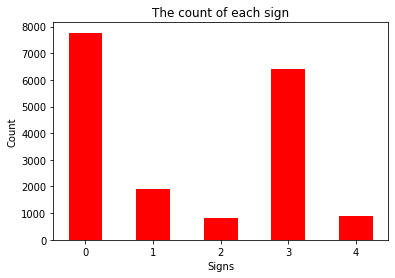

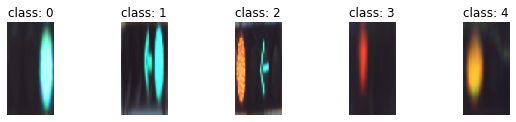

In [62]:
### Data exploration visualization.
fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(train_dataset.labels), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(train_dataset.labels == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(train_dataset.features[i].squeeze(), cmap='gray')

In [65]:
train_dataset = extend_dataset(PickledDataset(training_file))

class_sample_count = np.bincount(train_dataset.labels)
weights = 1 / np.array([class_sample_count[y] for y in train_dataset.labels])
samp = sampler.WeightedRandomSampler(weights, 5 * class_count)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, sampler=samp), to_device)

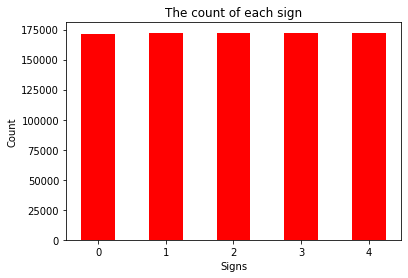

In [66]:
balanced_y_train = torch.LongTensor([]).to(device)

with torch.no_grad():
    for _, y in train_loader:
        balanced_y_train = torch.cat((balanced_y_train, y))

fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(balanced_y_train.cpu().numpy()), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

In [68]:
train_data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomApply([
        transforms.RandomRotation(20, resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, translate=(0.2, 0.2), resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, shear=20, resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, scale=(0.8, 1.2), resample=PIL.Image.BICUBIC)
    ]),
    transforms.ToTensor()
])
test_data_transforms = transforms.ToTensor()

train_dataset = extend_dataset(PickledDataset(training_file, transform=train_data_transforms))
#valid_dataset = PickledDataset(validation_file, transform=test_data_transforms)
test_dataset = PickledDataset(testing_file, transform=test_data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, sampler=samp), to_device)
#valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), to_device)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), to_device)

In [32]:
def convert_image_np(img):
    img = img.numpy().transpose((1, 2, 0)).squeeze()
    return img

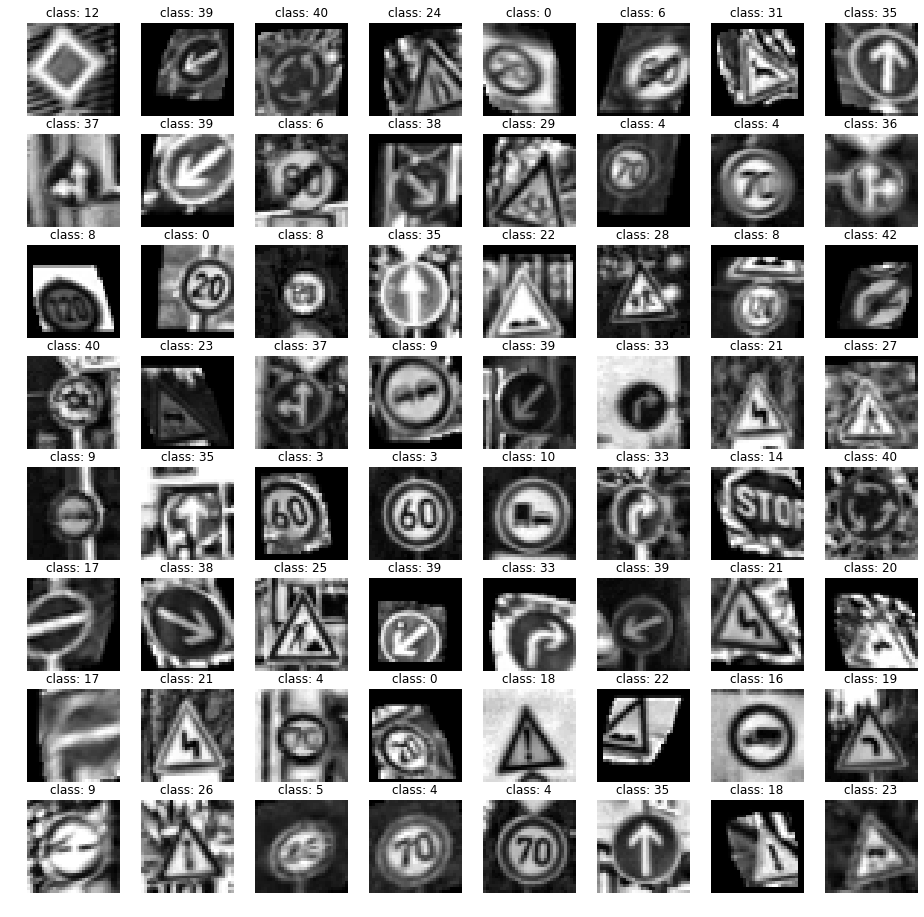

In [33]:
with torch.no_grad():
    x, y = next(iter(train_loader))
    plt.figure(figsize=(16, 16))
    for i in range(len(y)):
        plt.subplot(8, 8, i+1)
        plt.axis('off')
        plt.title('class: {}'.format(y[i]))
        plt.imshow(convert_image_np(x[i].cpu()), cmap='gray')

In [34]:
model = BaselineNet(gray=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/20] Train loss: 2.380466	Validation loss: 0.574594	 Validation accruacy: 81.995%
[Epoch 2/20] Train loss: 0.767553	Validation loss: 0.346210	 Validation accruacy: 90.567%
[Epoch 3/20] Train loss: 0.512051	Validation loss: 0.310381	 Validation accruacy: 92.018%
[Epoch 4/20] Train loss: 0.407675	Validation loss: 0.279048	 Validation accruacy: 91.655%
[Epoch 5/20] Train loss: 0.346381	Validation loss: 0.281919	 Validation accruacy: 93.129%
[Epoch 6/20] Train loss: 0.304579	Validation loss: 0.271469	 Validation accruacy: 94.036%
[Epoch 7/20] Train loss: 0.275263	Validation loss: 0.301138	 Validation accruacy: 92.834%
[Epoch 8/20] Train loss: 0.250592	Validation loss: 0.282794	 Validation accruacy: 93.673%
[Epoch 9/20] Train loss: 0.232405	Validation loss: 0.248254	 Validation accruacy: 94.558%
[Epoch 10/20] Train loss: 0.218885	Validation loss: 0.238033	 Validation accruacy: 94.558%
[Epoch 11/20] Train loss: 0.204253	Validation loss: 0.232611	 Validation accruacy: 93.832%
[Epoch 1

## Model

In [77]:
class TrafficSignNet(nn.Module):
    def __init__(self):
        super(TrafficSignNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 100, 5)
        self.conv1_bn = nn.BatchNorm2d(100)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(100, 150, 3)
        self.conv2_bn = nn.BatchNorm2d(150)
        self.conv3 = nn.Conv2d(150, 250, 1)
        self.conv3_bn = nn.BatchNorm2d(250)
        self.fc1 = nn.Linear(250 * 3 * 3, 350)
        self.fc1_bn = nn.BatchNorm1d(350)
        self.fc2 = nn.Linear(350, 43)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.elu(self.conv1(x)))
        x = self.dropout(self.conv1_bn(x))
        x = self.pool(F.elu(self.conv2(x)))
        x = self.dropout(self.conv2_bn(x))
        x = self.pool(F.elu(self.conv3(x)))
        x = self.dropout(self.conv3_bn(x))
        x = x.view(-1, 250 * 3 * 3)
        x = F.elu(self.fc1(x))
        x = self.dropout(self.fc1_bn(x))
        x = self.fc2(x)
        return x

In [80]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, patience=10):
    wait = 0
    valid_loss_min = np.Inf
    for epoch in range(epochs):
        # Train model
        model.train()
        losses, nums = zip(*[loss_batch(model, loss_func, x, y, opt) for x, y in train_dl])
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        # Validation model
        model.eval()
        with torch.no_grad():
            losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in valid_dl])
            valid_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            valid_accuracy = np.sum(corrects) / np.sum(nums) * 100
            print(f"[Epoch {epoch+1}/{epochs}] "
                  f"Train loss: {train_loss:.6f}\t"
                  f"Validation loss: {valid_loss:.6f}\t",
                  f"Validation accruacy: {valid_accuracy:.3f}%")
            # Save model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...")
                torch.save(model.state_dict(), 'model.pt')
                valid_loss_min = valid_loss
                wait = 0
            # Early stopping
            else:
                wait += 1
                if wait >= patience:
                    print(f"Terminated Training for Early Stopping at Epoch {epoch+1}")
                    return

In [82]:
n_epochs = 100
model = TrafficSignNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)

[Epoch 1/100] Train loss: 1.617526	Validation loss: 0.337216	 Validation accruacy: 91.429%
Validation loss decreased (inf --> 0.337216). Saving model...
[Epoch 2/100] Train loss: 0.815123	Validation loss: 0.183718	 Validation accruacy: 95.601%
Validation loss decreased (0.337216 --> 0.183718). Saving model...
[Epoch 3/100] Train loss: 0.607174	Validation loss: 0.131119	 Validation accruacy: 97.029%
Validation loss decreased (0.183718 --> 0.131119). Saving model...
[Epoch 4/100] Train loss: 0.491681	Validation loss: 0.110127	 Validation accruacy: 97.392%
Validation loss decreased (0.131119 --> 0.110127). Saving model...
[Epoch 5/100] Train loss: 0.413785	Validation loss: 0.104150	 Validation accruacy: 97.800%
Validation loss decreased (0.110127 --> 0.104150). Saving model...
[Epoch 6/100] Train loss: 0.361297	Validation loss: 0.095671	 Validation accruacy: 97.937%
Validation loss decreased (0.104150 --> 0.095671). Saving model...
[Epoch 7/100] Train loss: 0.323418	Validation loss: 0.088

In [83]:
check_point = torch.load('model.pt', map_location=device)
model.load_state_dict(check_point)
evaluate(model, criterion, test_loader)

Test loss: 0.035885	Test accruacy: 98.884%


# Spatial transformer networks

In [149]:
class Stn(nn.Module):
    def __init__(self):
        super(Stn, self).__init__()
        # Spatial transformer localization-network
        self.loc_net = nn.Sequential(
            nn.Conv2d(1, 50, 7),
            nn.MaxPool2d(2, 2),
            nn.ELU(),
            nn.Conv2d(50, 100, 5),
            nn.MaxPool2d(2, 2),
            nn.ELU()
        )
        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(100 * 4 * 4, 100),
            nn.ELU(),
            nn.Linear(100, 3 * 2)
        )
        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
    def forward(self, x):
        xs = self.loc_net(x)
        xs = xs.view(-1, 100 * 4 * 4)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

In [150]:
class TrafficSignNet(nn.Module):
    def __init__(self):
        super(TrafficSignNet, self).__init__()
        self.stn = Stn()
        self.conv1 = nn.Conv2d(1, 100, 5)
        self.conv1_bn = nn.BatchNorm2d(100)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(100, 150, 3)
        self.conv2_bn = nn.BatchNorm2d(150)
        self.conv3 = nn.Conv2d(150, 250, 1)
        self.conv3_bn = nn.BatchNorm2d(250)
        self.fc1 = nn.Linear(250 * 3 * 3, 350)
        self.fc1_bn = nn.BatchNorm1d(350)
        self.fc2 = nn.Linear(350, 43)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.stn(x)
        x = self.pool(F.elu(self.conv1(x)))
        x = self.dropout(self.conv1_bn(x))
        x = self.pool(F.elu(self.conv2(x)))
        x = self.dropout(self.conv2_bn(x))
        x = self.pool(F.elu(self.conv3(x)))
        x = self.dropout(self.conv3_bn(x))
        x = x.view(-1, 250 * 3 * 3)
        x = F.elu(self.fc1(x))
        x = self.dropout(self.fc1_bn(x))
        x = self.fc2(x)
        return x

In [151]:
model = TrafficSignNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)

[Epoch 1/100] Train loss: 0.647593	Validation loss: 0.099611	 Validation accruacy: 97.619%
Validation loss decreased (inf --> 0.099611). Saving model...
[Epoch 2/100] Train loss: 0.091612	Validation loss: 0.076996	 Validation accruacy: 98.209%
Validation loss decreased (0.099611 --> 0.076996). Saving model...
[Epoch 3/100] Train loss: 0.056867	Validation loss: 0.070488	 Validation accruacy: 98.322%
Validation loss decreased (0.076996 --> 0.070488). Saving model...
[Epoch 4/100] Train loss: 0.043221	Validation loss: 0.071348	 Validation accruacy: 98.413%
[Epoch 5/100] Train loss: 0.035300	Validation loss: 0.067215	 Validation accruacy: 98.526%
Validation loss decreased (0.070488 --> 0.067215). Saving model...
[Epoch 6/100] Train loss: 0.029878	Validation loss: 0.083907	 Validation accruacy: 98.345%
[Epoch 7/100] Train loss: 0.026623	Validation loss: 0.089166	 Validation accruacy: 98.435%
[Epoch 8/100] Train loss: 0.023175	Validation loss: 0.065774	 Validation accruacy: 98.481%
Validatio

In [152]:
check_point = torch.load('model.pt', map_location=device)
model.load_state_dict(check_point)
evaluate(model, criterion, test_loader)

Test loss: 0.027407	Test accruacy: 99.327%


## Visualizing the STN results

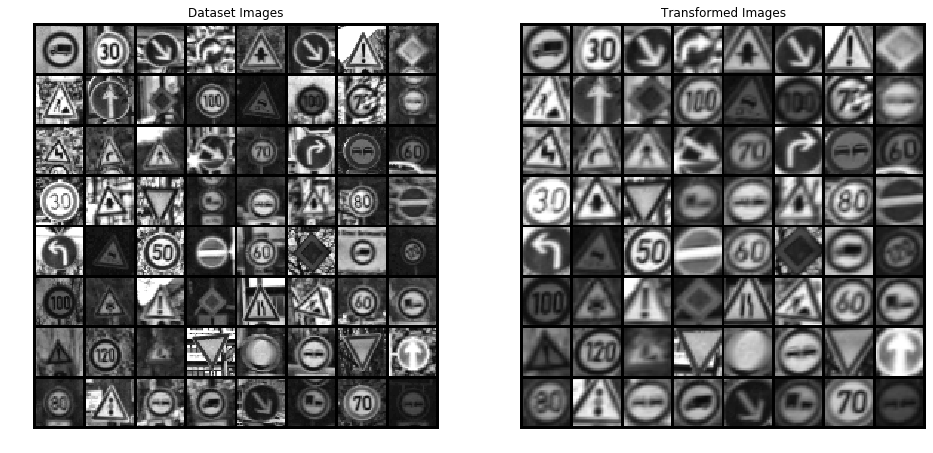

In [155]:
def visualize_stn():
    with torch.no_grad():
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_tensor = model.stn(data).cpu()

        input_grid = convert_image_np(make_grid(input_tensor))
        transformed_grid = convert_image_np(make_grid(transformed_tensor))

        # Plot the results side-by-side
        fig, ax = plt.subplots(1, 2)
        fig.set_size_inches((16, 16))
        ax[0].imshow(input_grid)
        ax[0].set_title('Dataset Images')
        ax[0].axis('off')

        ax[1].imshow(transformed_grid)
        ax[1].set_title('Transformed Images')
        ax[1].axis('off')
        
visualize_stn()